## Chapter 12: Introduction to nonlinear learning

# 12.1  Features, functions, and nonlinear regression

In this Section we introduce the general framework of nonlinear regression, along with many examples ranging from toy datasets to classic examples from differential equations.  These examples are all low dimensional, allowing us to visually examine patterns in the data and propose appropriate nonlinearities, which we can (as we will see) very quickly inject into our linear supervised paradigm to produce nonlinear regression fits.  By walking through these examples we flush out a number important concepts in concrete terms, coding principles, and jargon-terms in a relatively simple environment that will be omnipresent in our discussion of nonlinear learning going forward.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 12.1.1  Modeling principles of linear regression

In Chapter 8 we discussed linear regression, where we began with a very particular ideal desire to relate the input/output of a given dataset linearly as

\begin{equation}
w_0 + x_{1,p}w_1 + \cdots + x_{N,p}w_N  \approx y_p
\end{equation}

where the input $\mathbf{x}_p = \begin{bmatrix} x_{1,p}\\ \vdots \\ x_{N,p} \end{bmatrix}$ and output $y_p$ is the $p^{th}$ datapoint from a set of $P$ such points and $w_0$ is the bias and $w_1,\,w_2,\,...,\,w_N$ the slope parameters of our linear model.  This was our ideal scenario, that is, when these weights were tuned properly they all lie close to a particular hyperplane defined by the ideal weights. 

 The linear modeling assumption enters on the left side of each $\approx$ sign, our model which takes in a datapoint $\mathbf{x}_p$ and outputs a value we hope matches $y_p$ closely.  We can write our linear predictor more generically as
 
\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + x_{1}w_1 + \cdots + x_{N}w_N
\end{equation}

or more compactly in various ways e.g., as $\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathbf{x}^T \mathbf{w}^{\,}$ where we use our 'compact' notation denoting 

\begin{equation}
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N}
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathbf{x}=\begin{bmatrix}
1 \\
x_{1}\\
w_{2}\\
\vdots\\
w_{N}
\end{bmatrix},\,\,\,\,
\end{equation}

In Section 8.1.3 we implemented this linear `model` compactly in `Python` - allowing us to evaluate an entire dataset at once as shown below.

In [2]:
# compute linear combination of input point
def model(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
    
    # compute linear combination and return
    a = np.dot(x.T,w)
    return a.T

In our `model` notation we can express equation (1) as

\begin{equation}
\text{model}\left(\mathbf{x}_p, \mathbf{w}\right) \approx y_p.
\end{equation}

Moreover as we saw in our discussion of Least Squares linear regression in Section 8.1 the ideal scenario expressed above naturally leads to a Least Squares cost function

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) - y_p\right)^2
\end{equation}

whose minimum provides us with the weights that service our ideal as best as possible.

## 12.1.2  Modeling principles of general nonlinear regression

When first introducing this notation in Section 8.1.3 we discussed how separating out the `model` allowed us to both think about and implement linear regression cost functions in a more modular manner.  However it allows us directly move from linear to general *nonlinear* regression - in both its principles and implementation - with few obstacles.  How?  We simply swap out the linear `model` used in the construction of our regression - e.g., in equations (4) and (5) above - with a *nonlinear* one.  Indeed beginning with the *principle* we started with, beginning with the ideal scenario in equation (4) where we suppose we have perfect weights and ending with the Last Squares cost function in equation (5) for recovering them, we can see that there was nothing particular to this argument demanded that our `model` be a linear one.  This was an *assumption* we made - we chose a *linear* model to perform regression with.  

So instead of using a linear model we could instead use a nonlinear one, involving a single nonlinear function $f$ that can be parameterized or unparameterized (e.g., tanh, a sine wave, etc.,) as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right)  = 
w_0^{\,} + f\left(\mathbf{x}_p\right){w}_{1}^{\,}.
\end{equation}

In the jargon of machine learning / deep learning the nonlinear function $f$ is often called a nonlinear *feature transformation*, since we it transforms our original input features $\mathbf{x}$.

> In the jargon of machine learning / deep learning a nonlinear function $f$ used in any learning `model` is called a nonlinear *feature transformation*, since we it transforms our original input features $\mathbf{x}$.

Again we could consider the ideal case - where we have knowledge of the best possible weights so that 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) \approx y_p
\end{equation}

and to recover our ideal weights we would follow the same logic as previously: square the difference between both sides of the above and sum over all the points, giving the Least Squares cost function $
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) - y_p\right)^2
$ that - when minimized properly - still minimizes a squared error of our (now nonlinear) model and provides us with our desired weights.

<figure>
<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/nonlinear_regression.png' width="65%" height="65%" alt=""/>
</p>
<figcaption> <strong>Figure 2:</strong> <em> 
Shown here is the prototypical problem of nonlinear regression, which we achieve by injecting nonlinear feature transformations into our `model`.  As in the linear case here we aim to tune all parameters of our model to minimize an average error, here shown as vertical dashed lines measured from each point to the nonlinear `model`.
</em>
</figcaption>
</figure>

Indeed in general we could create a nonlinear model that is the weighted sum of $B$ nonlinear functions of our input as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + f_1\left(\mathbf{x}_p\right){w}_{1} +  f_2\left(\mathbf{x}_p\right){w}_{2} + \cdots + f_B\left(\mathbf{x}_p\right)w_B
\end{equation}

where $f_1,\,f_2,\,...\,f_B$ are nonlinear parameterized or unparameterized functions - or *feature transformations* - and $w_0$ through $w_B$ (along with any additional weights internal to the nonlinear functions) are represented in the weight set $\mathbf{w}$ and must be tuned properly.   Nonetheless the steps we take to formally employ such a model, its ideal weight values, the derivation of a Least Squares cost function, etc., are entirely similar to what we have now seen in the simpler instance of nonlinear regression (which itself does not differ from the steps taken in modeling the linear case).

> In extending linear to nonlinear regression we can use either parameterized or unparameterized nonlinear functions

## 12.1.3  Introductory examples of nonlinear regression

In this Subsection we walk through a number of simple examples of nonlinear regression where we can determine - by eye - a proper nonlinear `model` to use.  We then show how to implement and optimize each model by minimizing the corresponding Least Squares cost function.  These examples also allow us to introduce a number of important principles, formulations, and jargon-terms - that we will see considerably more of when discussing neural networks, tree-based learners, and kernels - in a comparatively simple context.

In terms of implementation, every example that follows employs the same `least_squares` function we first detailed in Section 8.1, and shown below (we can also use other cost functions for regression as well like e.g., the Least Absolute Deviation cost described in Section 8.3).

In [3]:
# an implementation of the least squares cost function for linear regression
def least_squares(w):
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(len(y))

For each example that follows our `model` implementation will also look very similar to its original version first shown in Section 8.1, with one very important new line.  We now compute desired feature transformations of the input $\mathbf{x}$ - which will also take in parameters depending on the particular feature transformations employed - via the `Python` function called `feature_transforms`.  The implementation of `model` below is written generically for the case where our desired feature transformations have internal parameters (hence why `feature_transforms` takes in the set of weights assigned to `w[0]`, with the weights in the final linear combinatin of the model stored in `w[1]`).  If - for example - the feature transformations being used do not have internal parameters the call to `feature_transforms` in line 4 below would instead look like


                                f = feature_transforms(x)
                        
                        
and the linear combination of transformed features in line 11 instead


                                a = np.dot(f.T,w)

In [4]:
# an implementation of our model employing a nonlinear feature transformation
def model(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(f)[1]))
    f = np.vstack((o,f))
    
    # compute linear combination and return
    a = np.dot(f.T,w[1])
    return a.T

Since these blocks of code will be generally the same across our examples we will not repeat them so that we can focus our attention in each case on how to implement particular feature transformations as the `Python` function `feature_transforms`.  We will employ these functions - along with the normalization modules and gradient descent optimizer we have implemented in previous Chapters - via a backend file `basic_runner.py`.

#### <span style="color:#a50e3e;">Example 1. </span> The linear case

As a first and simple example we can write the `feature_transforms` function for the simple case of linear regression and see how it can be directly plugged into our `model`, tuned, etc.,  Below we load in a dataset that clearly looks like a linear model would fit well if its parameters were properly tuned.

<IPython.core.display.Javascript object>


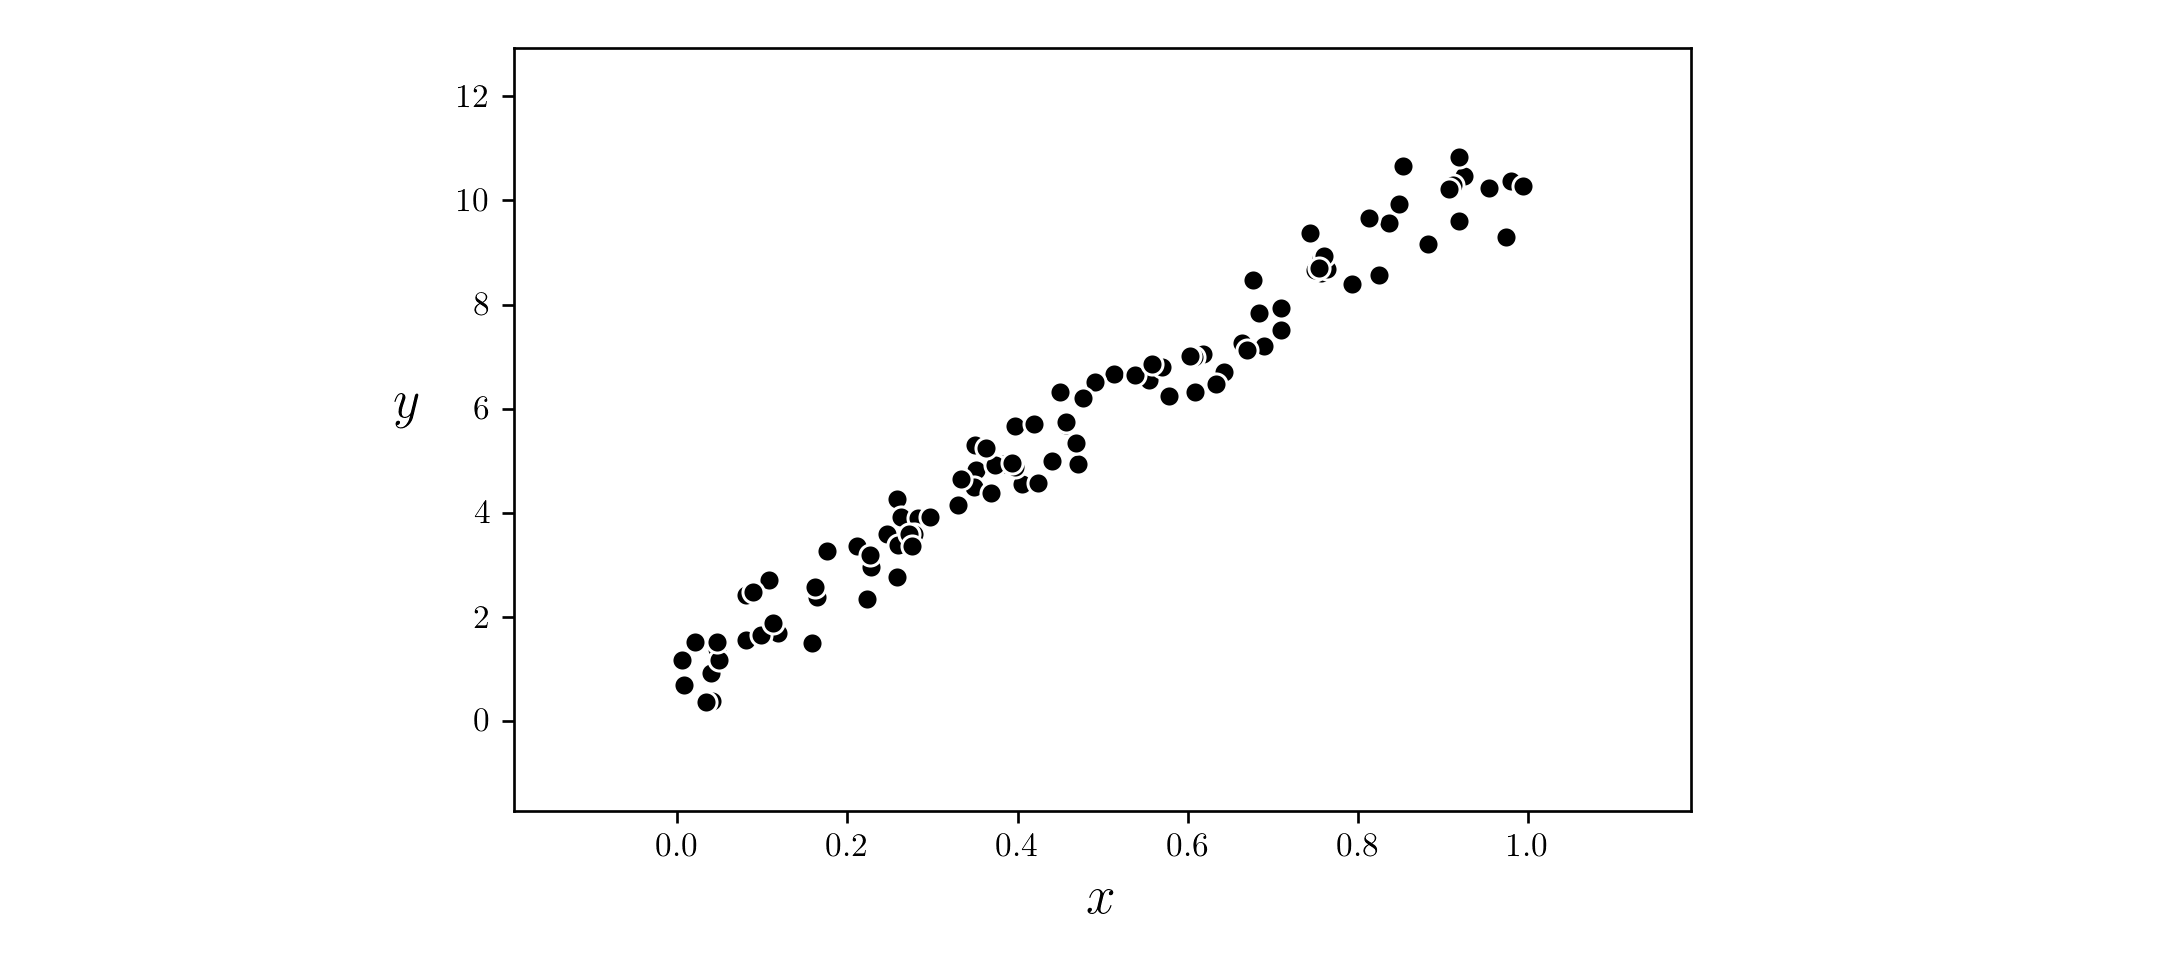

In [17]:
# load data
data = np.loadtxt(datapath + 'unnorm_linregress_data.csv',delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

Here we would propose to use the standard sort of linear model we saw in previous Chapters

\begin{equation}
\text{model}\left(x,\mathbf{w}_{\!}\right) = w_0 + xw_1.
\end{equation}

Here - although we did not explicitly call it such - we are employing the simple linear feature transformation

\begin{equation}
f\left(x\right) = x
\end{equation}

and in this notation our `model` is then equivalently

\begin{equation}
\text{model}\left(x,\mathbf{w}_{\!}\right) = w_0 +f\left(x\right)w_{1\,}.
\end{equation}

This is a rather trivial feature transformation to implement in `Python` - as we do below.  Notice here how the linear feature transformation is *unparameterized*.

In [19]:
# the trivial linear feature transformation
def feature_transforms(x):
    return x

Below we perform a run of gradient descent on this dataset - first performing standard normalization on the input as detailed in Section 8.4.  Performing standard normalization (subtracing the mean and dividing off the standard deviation of the input) we can actually think of the normalization as being a part of the feature transformation itself, and write it formally as

\begin{equation}
f\left(x \right) = \frac{x - \mu}{\sigma}
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset's input.  There is no need however to adjust the `feature_transforms` implementation to reflect this, since we can construct this version of our feature transformation by composing it with a function `normalizer` function that performs the standard normalization (as detailed in e.g., Section 8.4) as `feature_transforms(normalizer(x))`.

In [21]:
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(2,1); max_its = 500; alpha_choice = 10**(-1)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

We can then plot the line correspnoding to those weights providing the lowest cost function value during the run, as we do below.  The fit does indeed match the behavior of the dataset well.

<IPython.core.display.Javascript object>


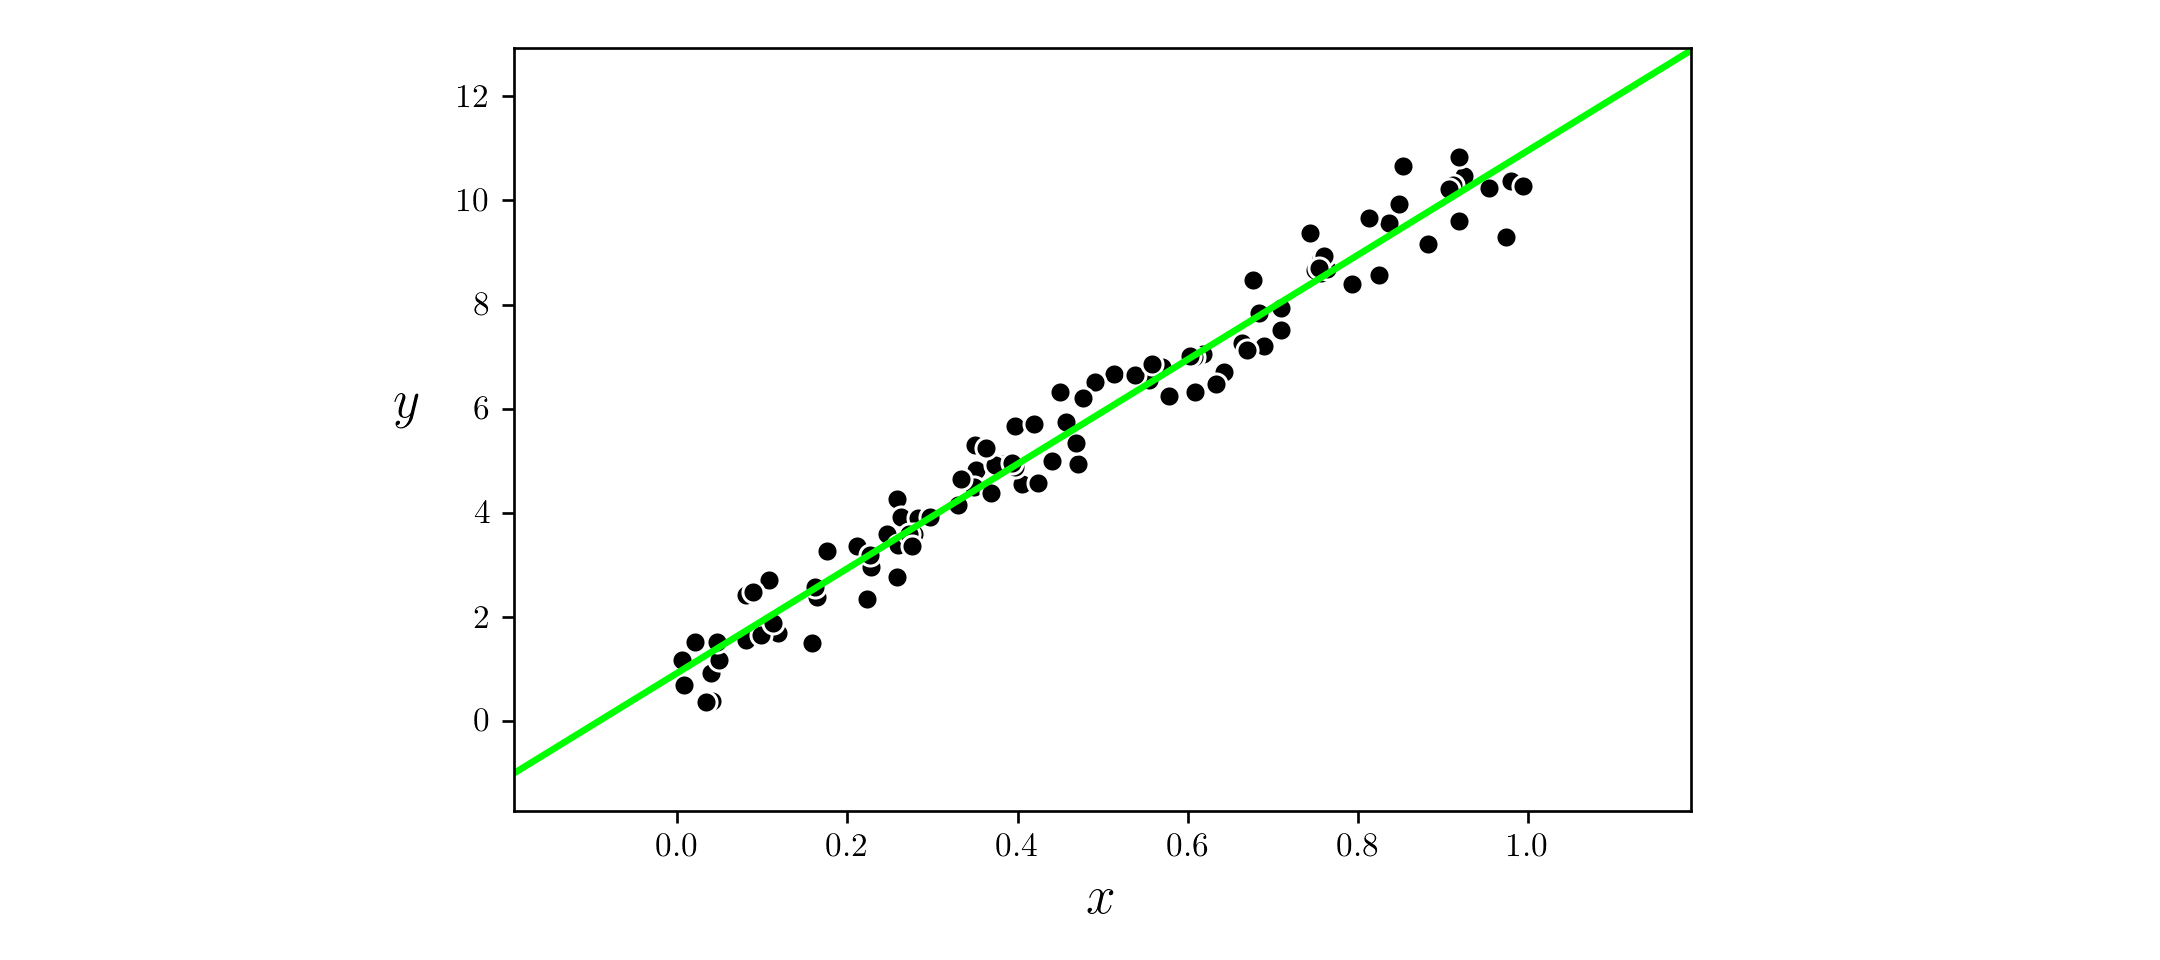

In [25]:
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit(w_best,run.model,normalizer = run.normalizer);

#### <span style="color:#a50e3e;">Example 2. </span> Modeling a familiar wave using a parameterized feature transformation

Lets look at the following wavy looking regression dataset, postulate an appropriate nonlinear `model`, implement it and fit it to the data by minimizing the corresponding Least Squares cost.

<IPython.core.display.Javascript object>


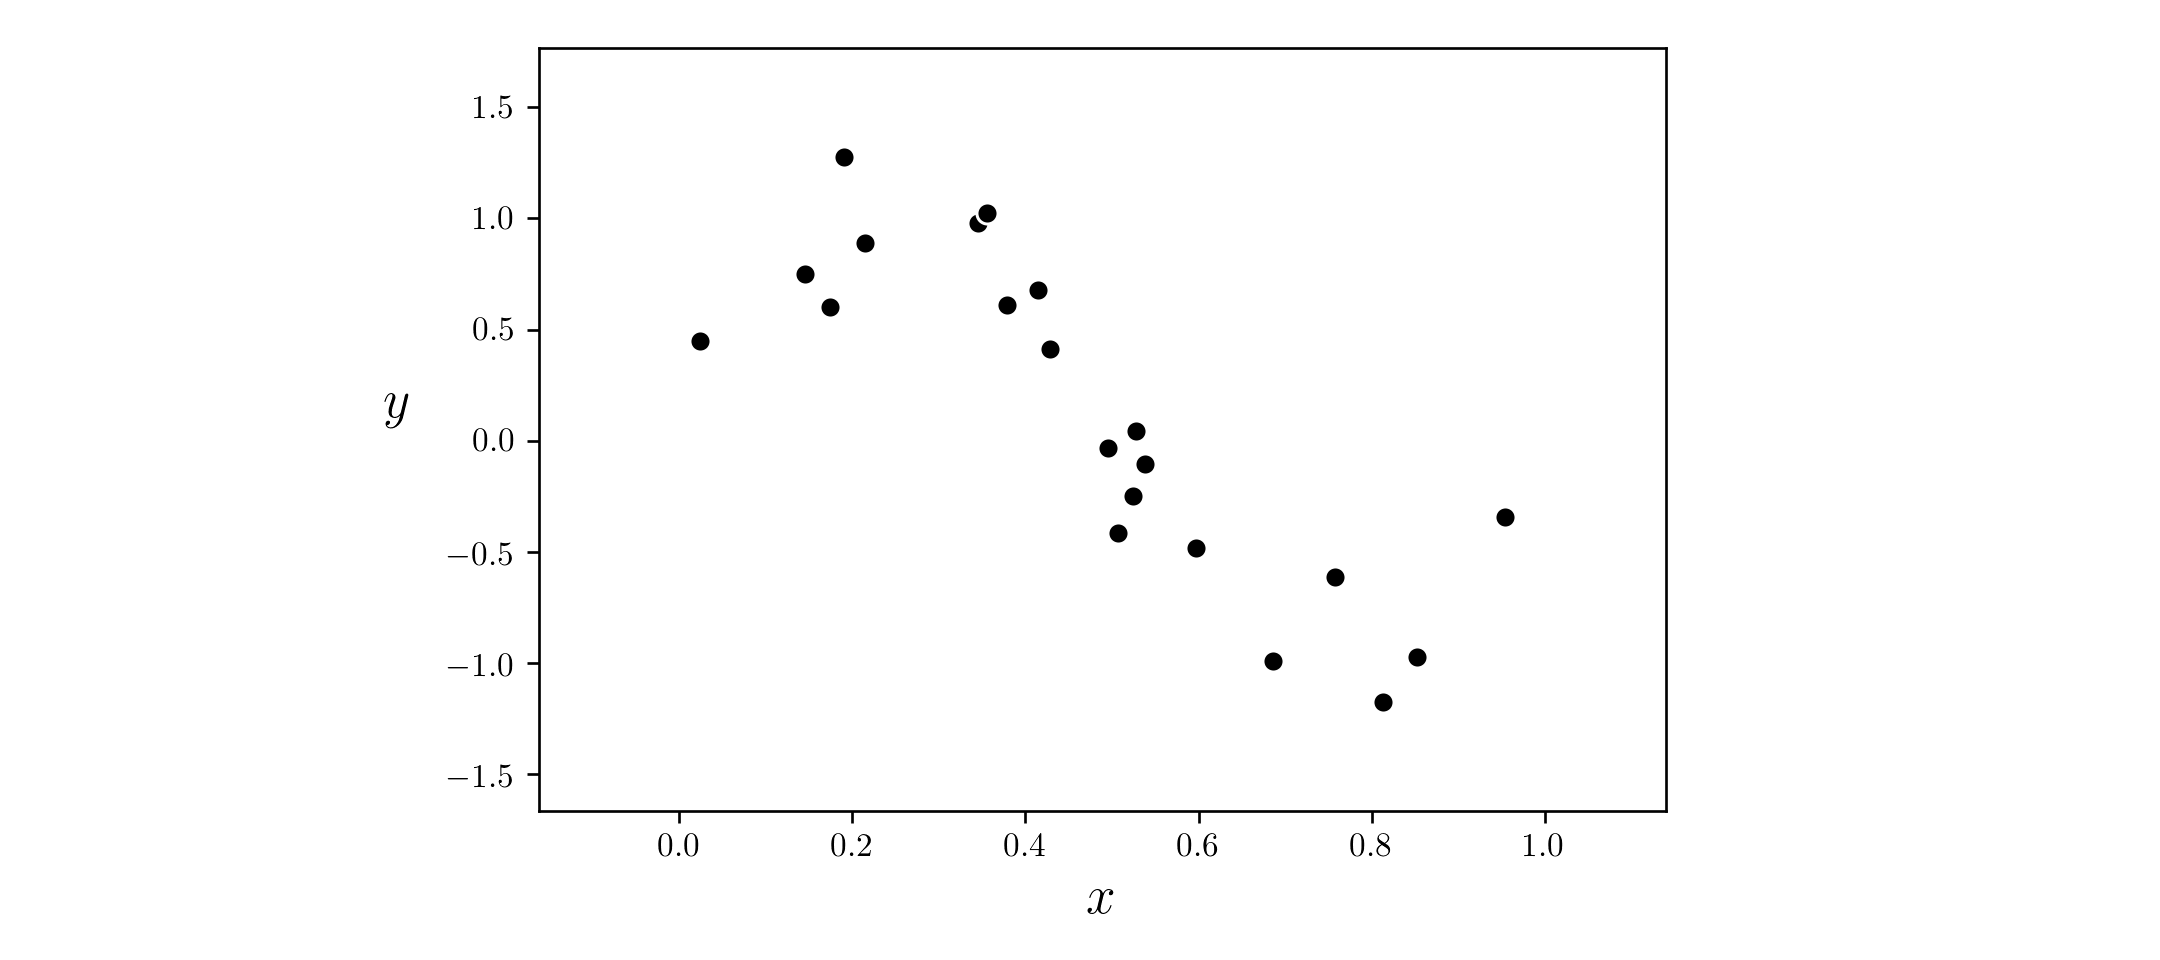

In [27]:
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

This dataset looks sinusoidal, so we can defensibly propose a `model` consisting of completely *parameterized* sine function or *feature transformation* 

\begin{equation}
f\left(x,\mathbf{w}\right) = \text{sin}\left(w_0 + xw_1\right).
\end{equation}

We can then take as our model a linear combination of this nonlinear feature transformation as

\begin{equation}
\text{model}\left(x,\mathbf{w}_{\!}\right) = w_2 + f\left(x,\mathbf{w}\right)w_{3\,}.
\end{equation}

Note here we are using the notation $\mathbf{w}$ rather loosely to represent whatever weights are present in the respective formula - for example in the feature transformation $\mathbf{w}$ consists of $w_0$ and $w_1$, whereas with the `model` it contains these weights as well as $w_2$ and $w_3$.

This seems like it could fit the data well if its parameters were all tuned properly via e.g., minimizing the associated Least Squares cost.  However first we need to implement our feature transformation in `Python`, which we will do below.

In [28]:
# our nonlinearity, known as a feature transformation
def feature_transforms(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
        
    # calculate feature transform
    f = np.sin(np.dot(x.T,w)).T
    return f

Below we make a run of gradient descent on the original and standard normalized versions of the input, and compare their cost function histories afterwards.  *Input normalization* - discussed in the context of *linear* regression in Sections 8.4 and 11.3 - is equally important in the context of nonlinear regression (we will have much more to say on this topic in future Sections) in terms of tempering the contours of any regression cost function making it considerably easier for gradient descent to minimize. 

In [33]:
# parameters for our two runs of gradient descent
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
max_its = 500; alpha_choice = 10**(-1)

# run on original data
run1 = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'None')
run1.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

# run on normalized data
run2 = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run2.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

Now we compare the cost function histories of each run in the cost function plot below.  This sort of result is very typical of nonlinear regression and while we will not normalize the input of every *toy* example discussed in this and the next Sections for reasons of clarity, it serves as an important reminder that in practice one should *never forget to normalize input* when tuning a nonlinear supervised learner via gradient descent.  The run on the original data is actually somewhat deceiving here - it converges but not to the global minimum achieved using the normalized input.

<IPython.core.display.Javascript object>


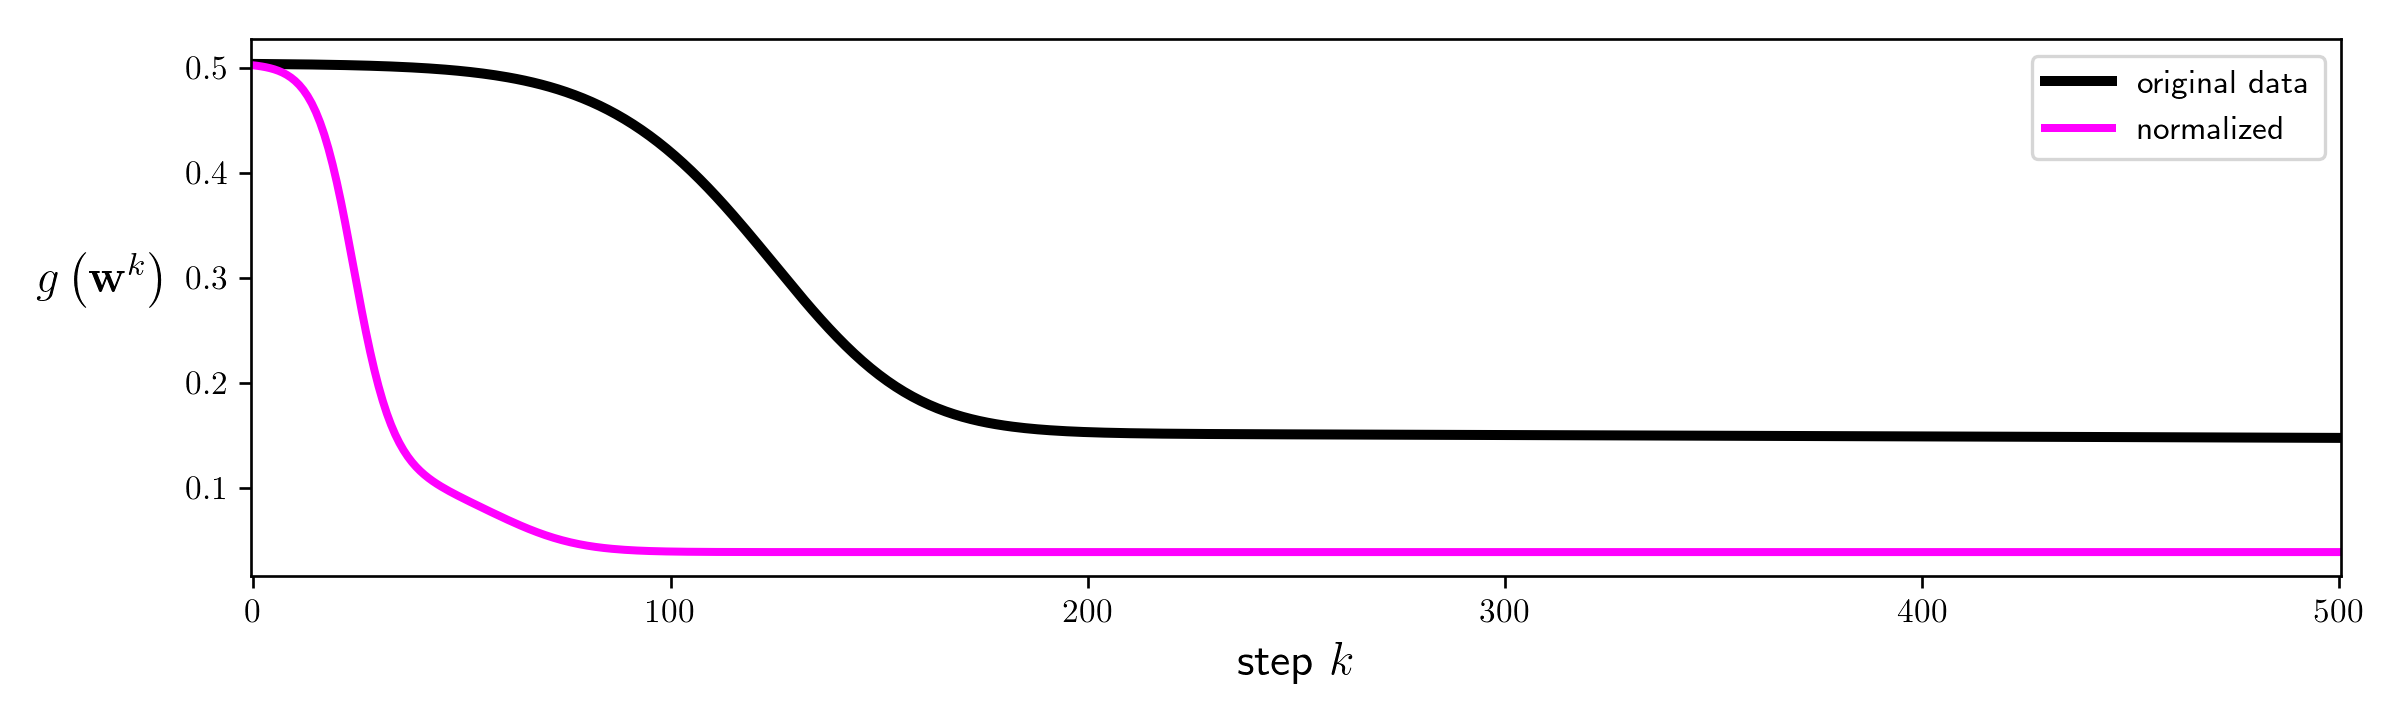

In [34]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([run1.cost_history,run2.cost_history],start = 0,points = False,labels = ['original data','normalized'])

We can then plot the resulting fit to the data provided by the run on the normalized input - and achieve quite a good fit.

<IPython.core.display.Javascript object>


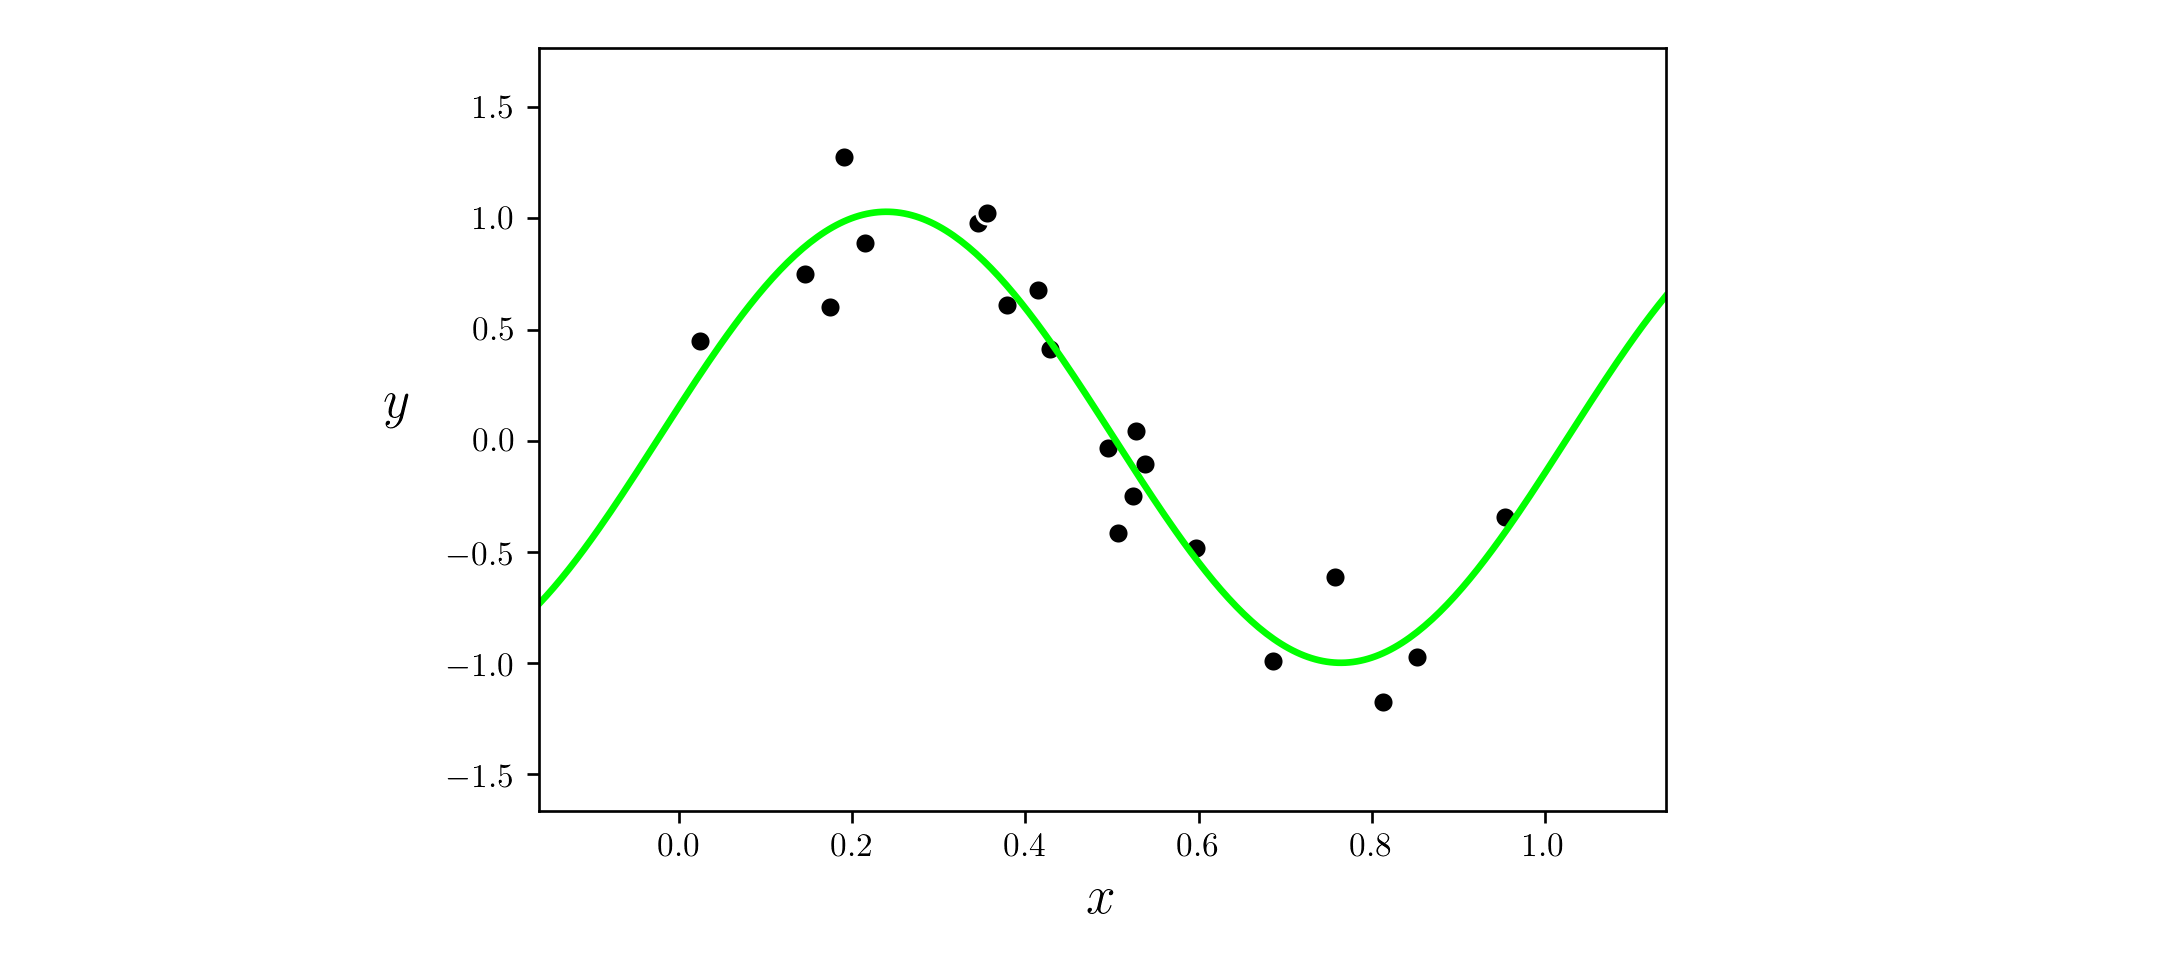

In [35]:
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run2.cost_history)
w_best = run2.weight_history[ind]
demo.plot_fit(w_best,run2.model,normalizer = run2.normalizer);

Note as with the previous example that since we have used standard normalization to scale our input, we can write our feature transformation as 

\begin{equation}
f\left(x,\mathbf{w}\right) = \text{sin}\left(w_0 + \frac{x - \mu}{\sigma}w_1\right)
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of our input data respectively.  Once again we need not adjust our actual implementation `feature_transforms`, since we accomplish this formula in `Python` by composing the function with the standard `normalizer` function as `feature_transforms(normalizer(x))`.

With our weights fully tuned to our ideal parameters $\mathbf{w}^{\star}$ notice that  since `model` is defined *linearly* in terms of its feature transformation we can represent our transformed input $x_p \longleftarrow f\left(x_p,\mathbf{w}^{\star}\right)$ and the correspnoding model fit $
\text{model}\left(x,\mathbf{w}^{\star}\right)$ in what is called the *transformed feature space*.  This is simply the space whose input is the feature transformed input $\left(x,\mathbf{w}^{\star}\right)$ and whose output remains as $y$.  In this space our *nonlinear* fit is a *linear* one.  In other words, with our model completely tuned if plot the points $\left(f\left(x_1,\mathbf{w}^{\star}\right),y_1\right),\,\left(f\left(x_2,\mathbf{w}^{\star}\right),y_2\right)...,\left(f\left(x_P,\mathbf{w}^{\star}\right),y_P\right)$ - as we do below in the right panel - our model fits the transformed data *linearly*.

This finding is true in general with nonlinear regression problems.

> A properly designed feature (or set of features) provides a good nonlinear fit in the original feature space and, simultaneously, a good linear fit in the transformed feature space.

<IPython.core.display.Javascript object>


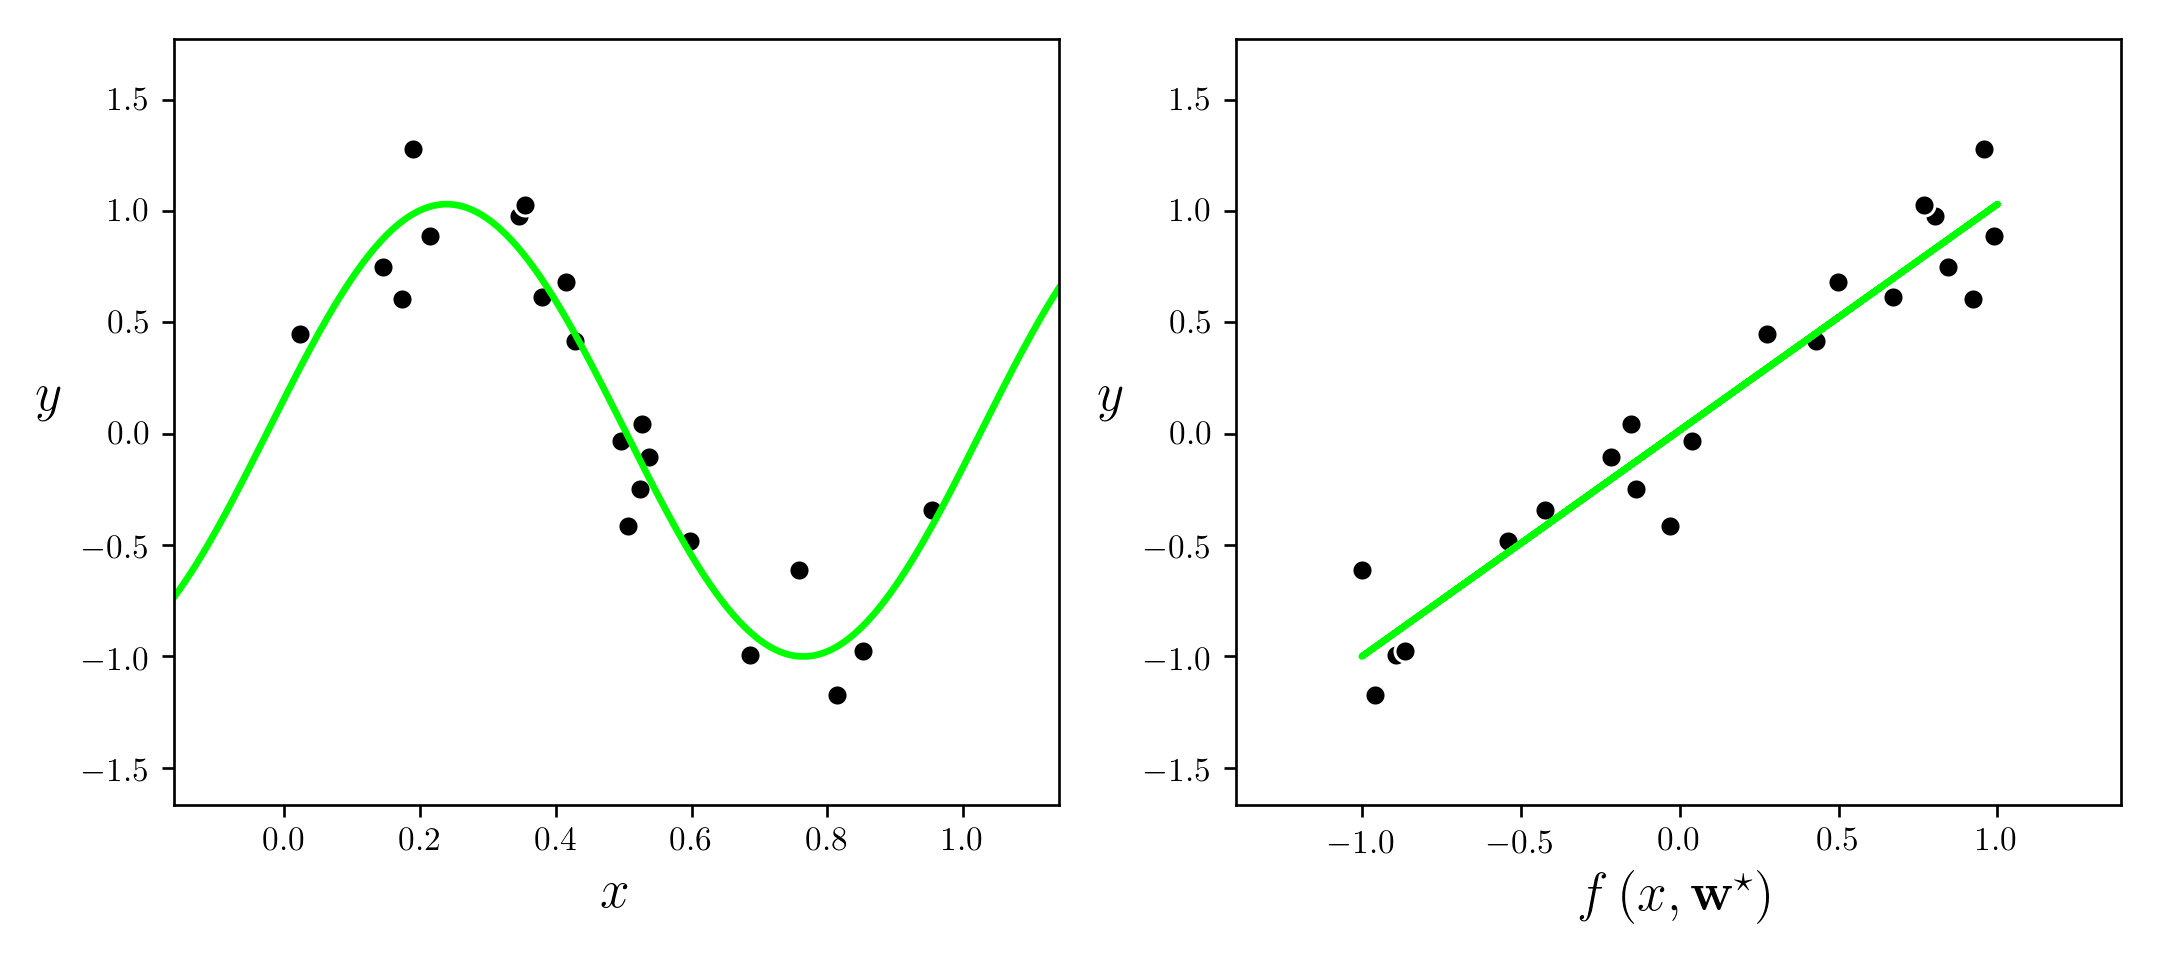

In [36]:
# plot data and fit in original and feature transformed space
demo.plot_fit_and_feature_space(w_best,run2.model,run2.feature_transforms,normalizer = run2.normalizer)

#### <span style="color:#a50e3e;">Example 3. </span> Modeling population growth using a parameterized feature transformation

Next we examine a population growth dataset - which shows the population of Yeast cells growing in a constrained chamber (you can find the [source of this dataset here](http://math.arizona.edu/~dsl/byeast.htm)).  This is a common shape found with population growth data, where the creature under study starts off with only a few members and is only limited in growth by how fast it can reproduce and the resources available in its environment.  In the beginning such a population grows exponentially.  This growth halts rapidly when the population reaches the maximum carrying capacity of its environment.

<IPython.core.display.Javascript object>


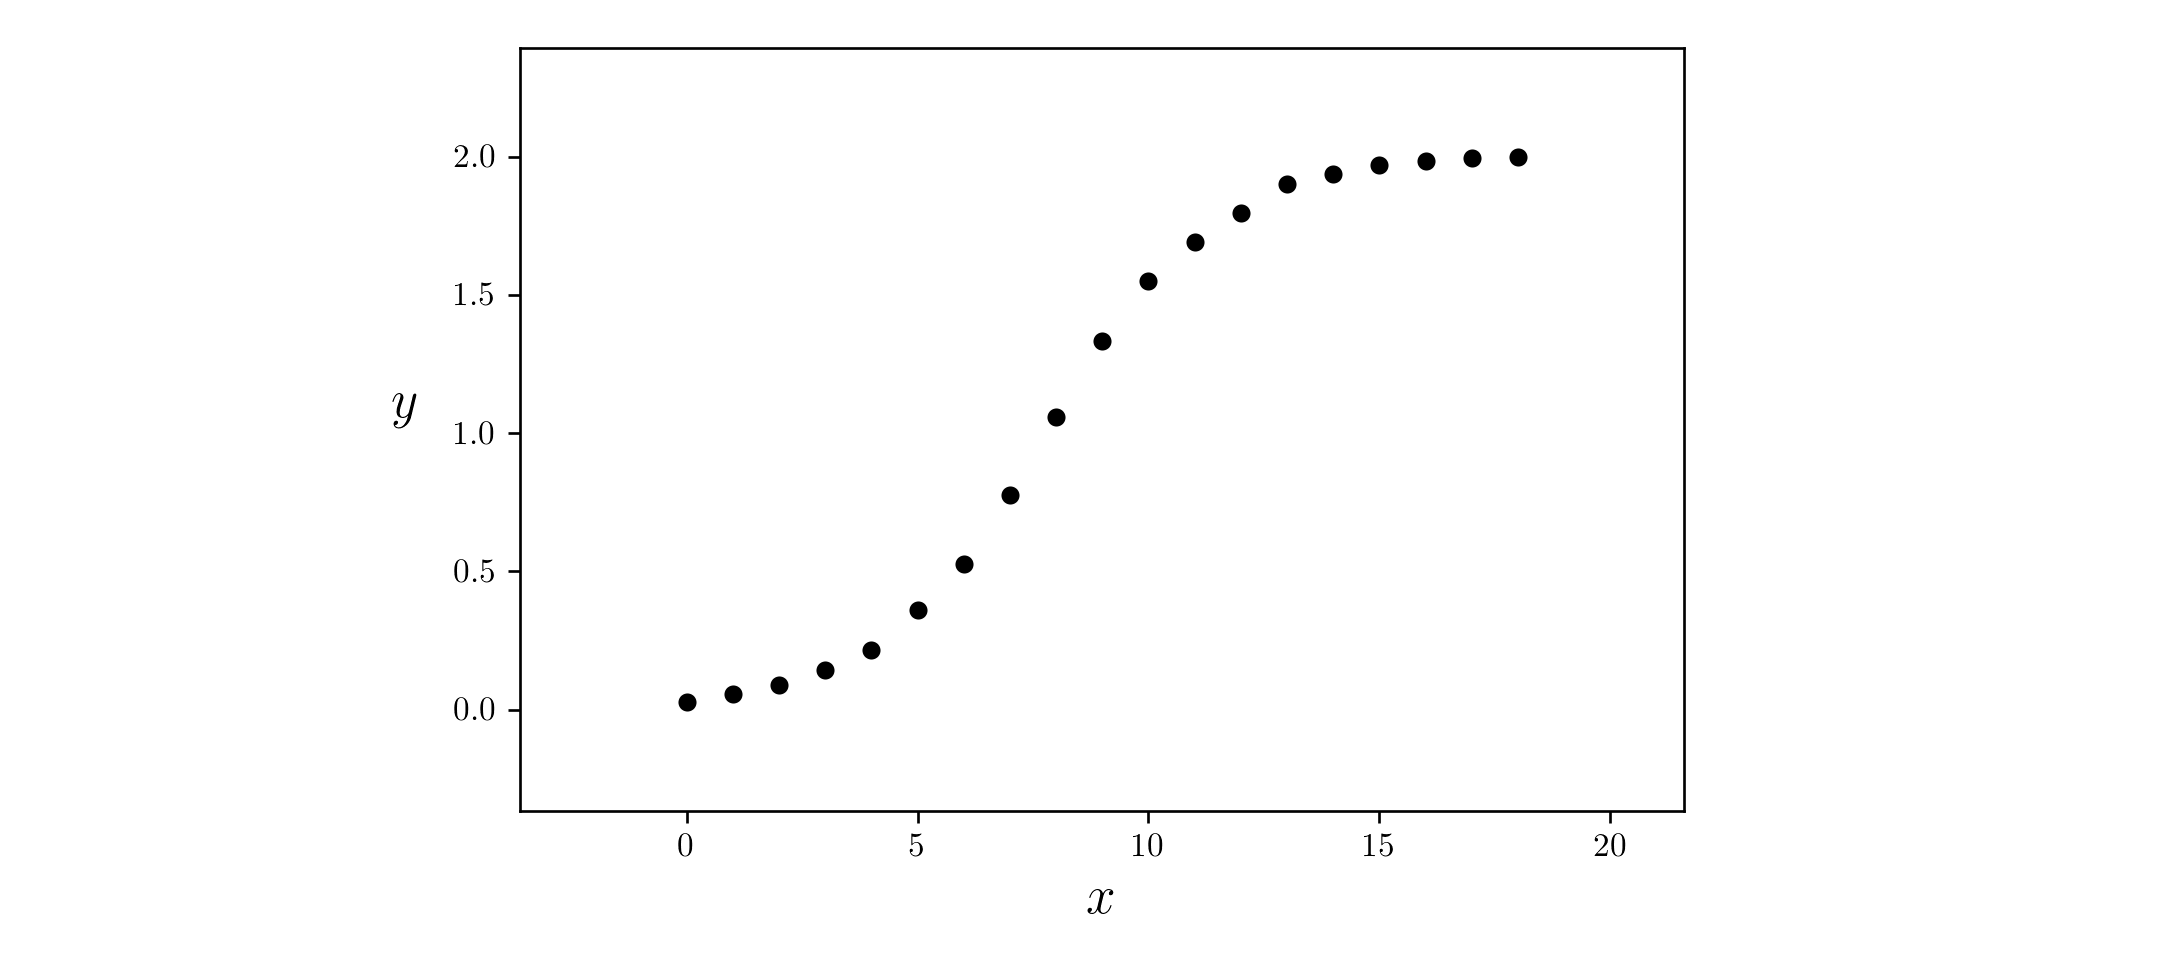

In [38]:
# load data
csvname = datapath + 'yeast.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

If we take a moment and visually examine this dataset, it appears that some sort of logistic sigmoid / hyperbolic tangent nonlinearity would fit it quite well.  So using a *parameterized* tanh feature transformation 

\begin{equation}
f\left(x,\mathbf{w}\right) = \text{tanh}\left(w_0 + xw_1\right).
\end{equation}

we can then take as our `model` a linear combination of this nonlinear feature transformation as

\begin{equation}
\text{model}\left(x,\mathbf{w}_{\!}\right) = w_2 + f\left(x,\mathbf{w}\right)w_{3\,}.
\end{equation}

Note here we are using the notation $\mathbf{w}$ rather loosely to represent whatever weights are present in the respective formula - for example in the feature transformation $\mathbf{w}$ consists of $w_0$ and $w_1$, whereas with the `model` it contains these weights as well as $w_2$ and $w_3$.

Below we show an implementation of this feature transformation and associated model.

In [39]:
# our nonlinearity, known as a feature transformation
def feature_transforms(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
        
    # calculate feature transform
    f = np.tanh(np.dot(x.T,w)).T
    return f

Using the same functionality employed in the previous example, we normalize the input of this dataset (using standard normalization) since this virtually always helps speed up gradient descent significantly.  Note this means that our feature transformation can be written as

\begin{equation}
f\left(x_p,\mathbf{w}\right) = \text{tanh}\left(w_0 + \frac{x_p - \mu}{\sigma}w_1\right)
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of our input data respectively.  We do not need to alter our feature transformation code above make this change, since it can be accomplished by feeding in the normalized input for training and the corresponding normalization function while evaluating test points.

Below we then form the corresponding Least Squares cost, and minimize it using gradient descent.  

In [42]:
# parameters for our two runs of gradient descent
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
max_its = 1000; alpha_choice = 10**(-1);

# run on original data
run1 = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run1.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

To check the convergence of our run of gradient descent we show the corresponding cost function history plot below.

<IPython.core.display.Javascript object>


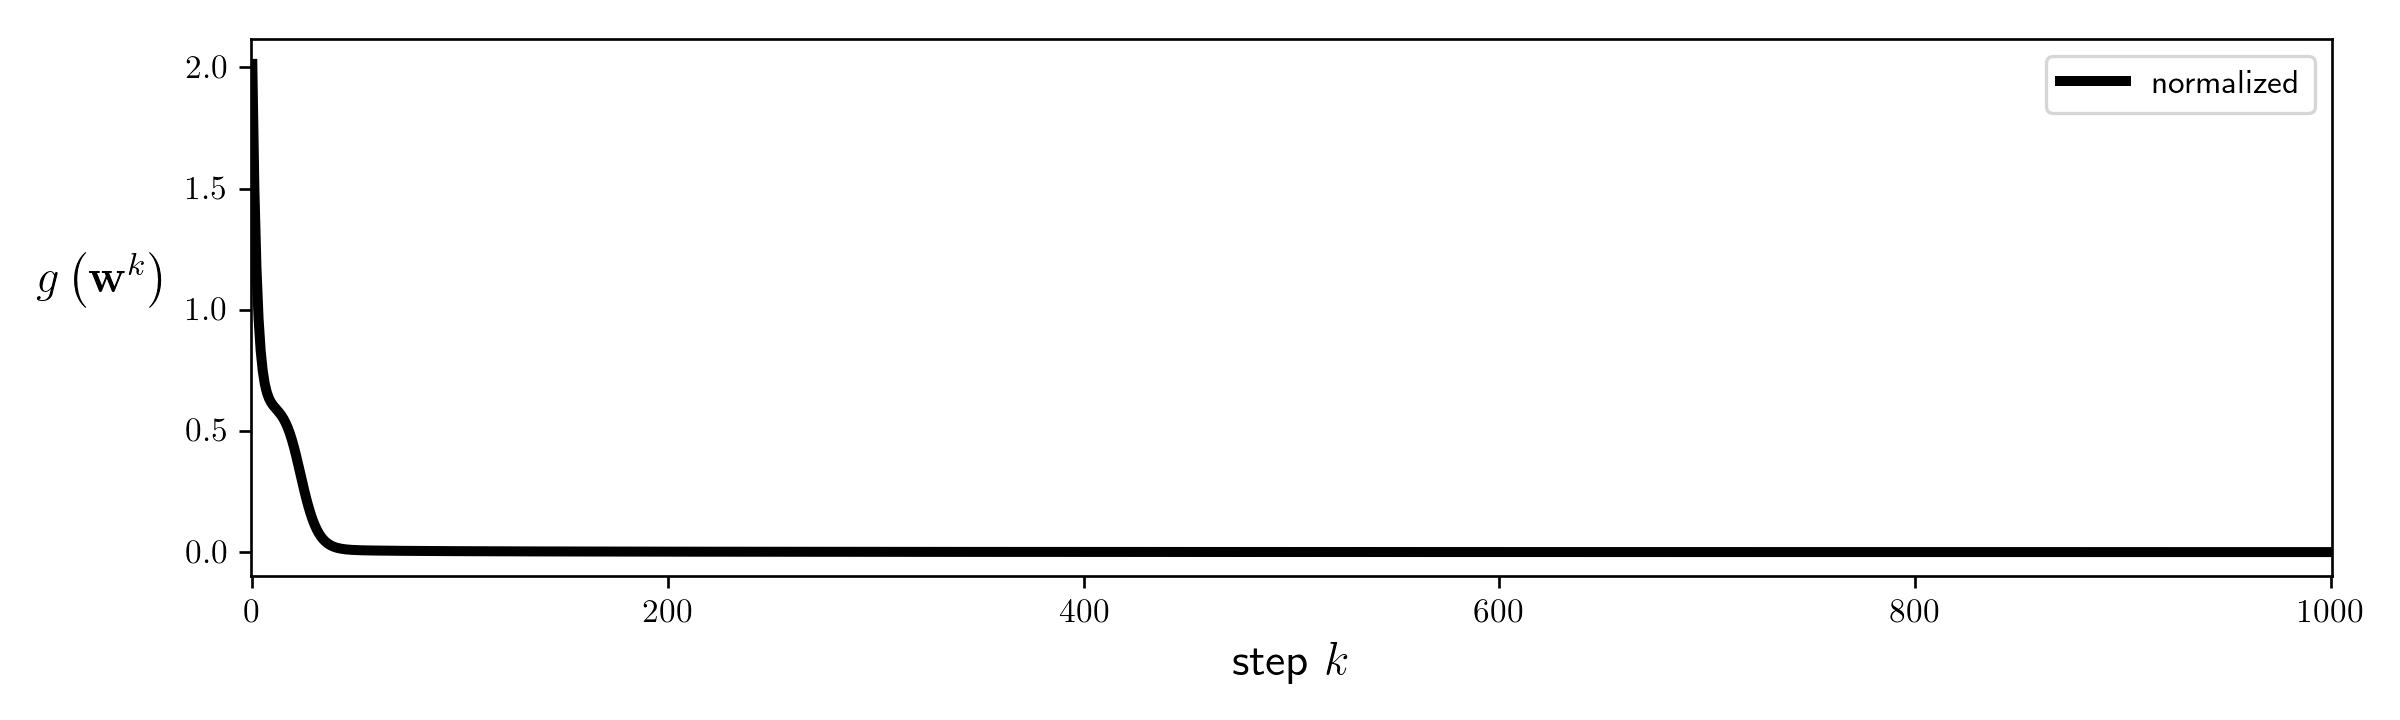

In [43]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([run1.cost_history],start = 0,points = False,labels = ['normalized'])

With our minimization complete we can then fit our `model` function in both the original space (where it provides a good nonlinear fit) as well as in the *transformed feature space* where it simultaneously provides a good linear fit to the transformed data (as discussed in the previous example).

<IPython.core.display.Javascript object>


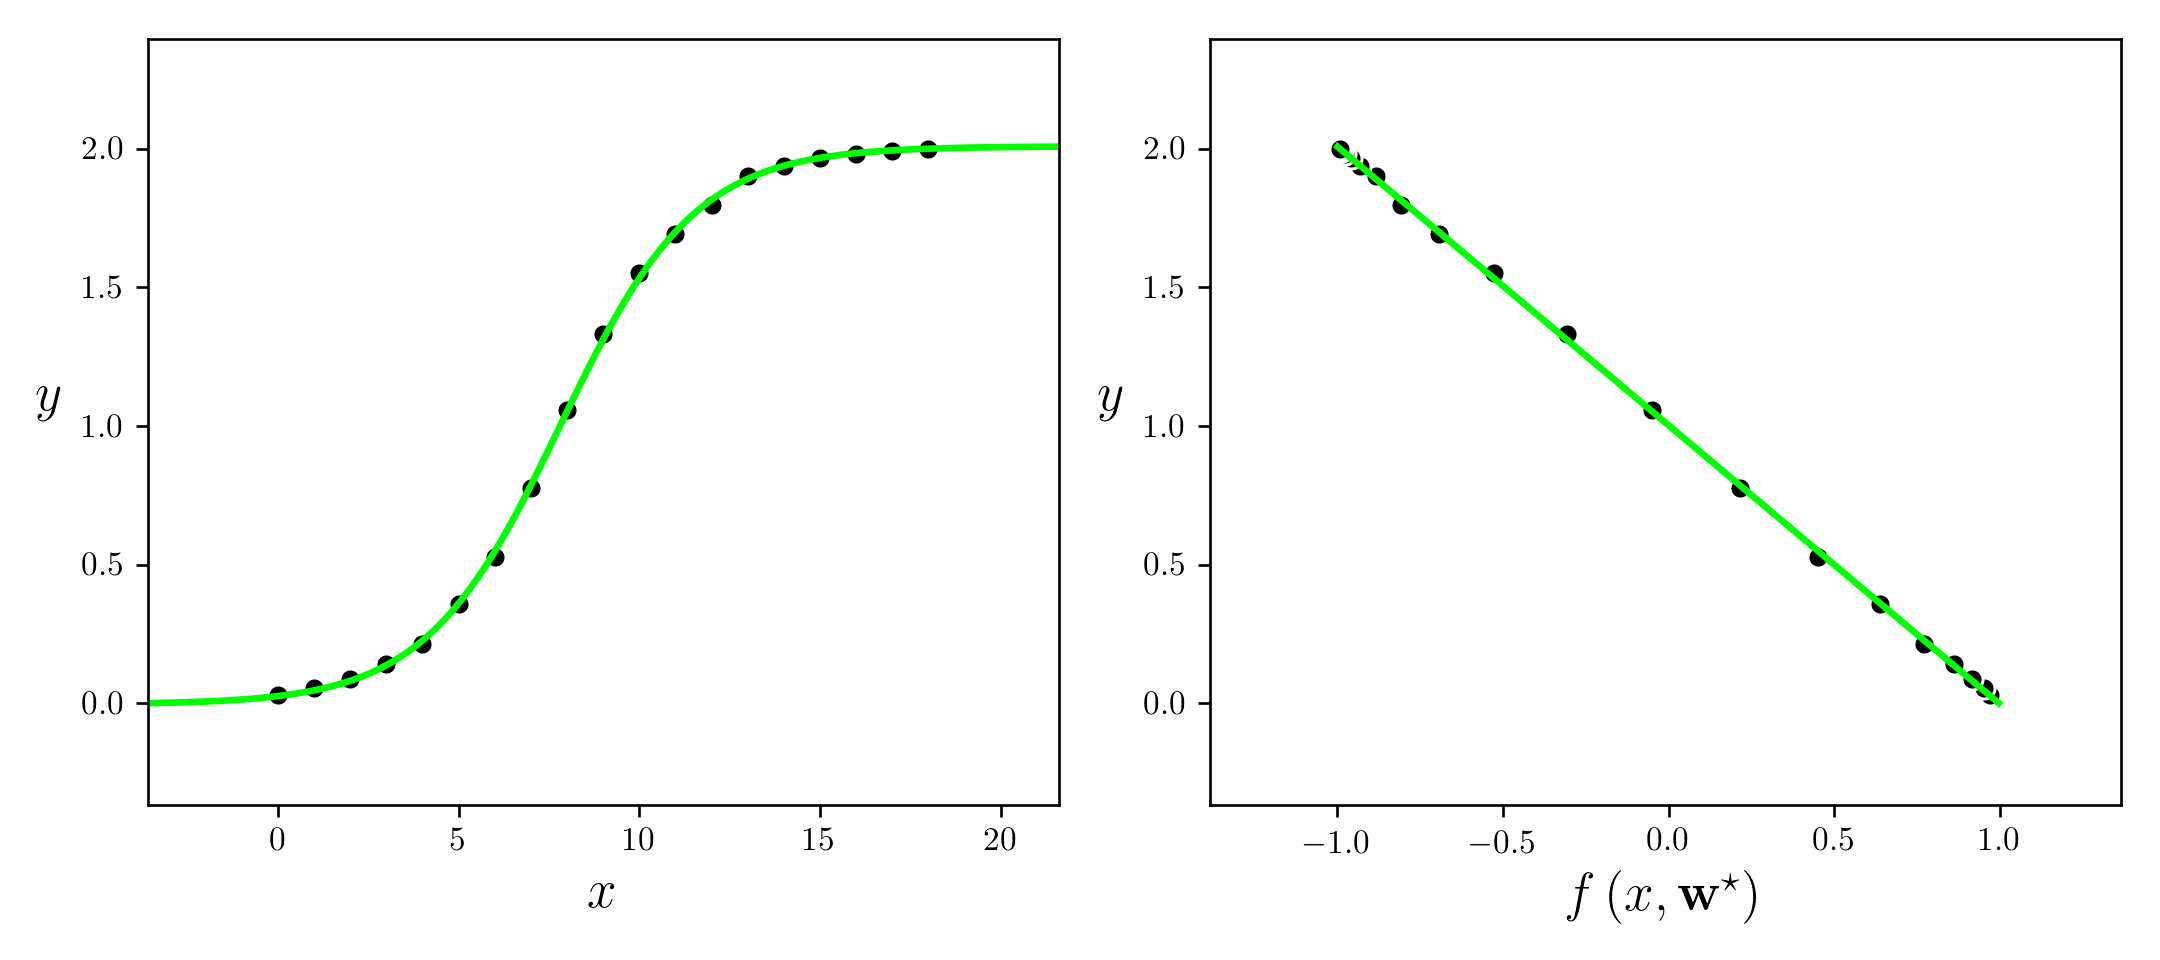

In [44]:
# plot data and fit in original and feature transformed space
ind = np.argmin(run1.cost_history)
w_best = run1.weight_history[ind]
demo.plot_fit_and_feature_space(w_best,run1.model,run1.feature_transforms,normalizer = run1.normalizer)

#### <span style="color:#a50e3e;">Example 4. </span> Using an unparameterized feature transformation to model a classic physics dataset

In 1638 Galileo Galilei, infamous for his expulsion from the Catholic church for daring to claim that the earth orbited the sun and not the converse (as was the prevailing belief at the time) published his final book: [Discourses and Mathematical Demonstrations Relating to Two New Sciences](https://books.google.com/books?hl=en&lr=&id=8BhZAAAAYAAJ&oi=fnd&pg=PA11&ots=5pQfKe7Bby&sig=VVWwm0GtVvS9YnydNJXHU_UxBjA#v=onepage&q&f=false). In this book, written as a discourse among three men in the tradition of Aristotle, he described his experimental and philosophical evidence for the notion of uniformly accelerated physical motion. Specifically, Galileo (and others) had intuition that the acceleration of an object due to (the force we now know as) gravity is uniform in time, or in other words that the distance an object falls is directly proportional (i.e., linearly related) to the amount of time it has been traveling, squared. This relationship was empirically solidified using the following ingeniously simple experiment performed by Galileo.

Repeatedly rolling a metal ball down a grooved $\frac{1}{2}$ meter long piece of wood set at an incline as shown in the Figure below, Galileo timed how long the ball took to get $\frac{1}{4}$,$\frac{1}{2}$, $\frac{2}{3}$, $\frac{3}{4}$, and all the way down the wood ramp. 

<p>
<figure>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/Fig_1_12.png' width="80%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 5:</strong> <em> Figurative illustration of
Galileo's ramp experiment setup used for exploring the relationship
between time and the distance an object falls due to gravity. To perform
this experiment he repeatedly rolled a ball down a ramp and timed
how long it took to get $\frac{1}{4}$,$\frac{1}{2}$, $\frac{2}{3}$,
$\frac{3}{4}$, and all the way down the ramp.  </em>  </figcaption> 
</figure>
</p>

 Why didn't Galileo simply drop the ball from some height and time how long it took to reach certain distances to the ground?  Because no reliable way to measure time yet existed (he had to use a [water clock](https://en.wikipedia.org/wiki/Water_clock) for these experiments)!   Galileo was the one who set humanity on the route towards its first reliable time-piece in his studies of the [pendulum](http://galileo.rice.edu/sci/instruments/pendulum.html)
 
Data from a ([modern reenactment](Straulino, S, "Reconstruction of Galileo Galilei's experiment: the inclined plane", Physics Education 43, 3 2008, pp. 316.)) of these experiments (averaged over 30 trials), results in the 6 data points shown below.  Here the input axis is the number seconds while the output is the portion of the ramp traveled by the ball during the experiments.

<IPython.core.display.Javascript object>


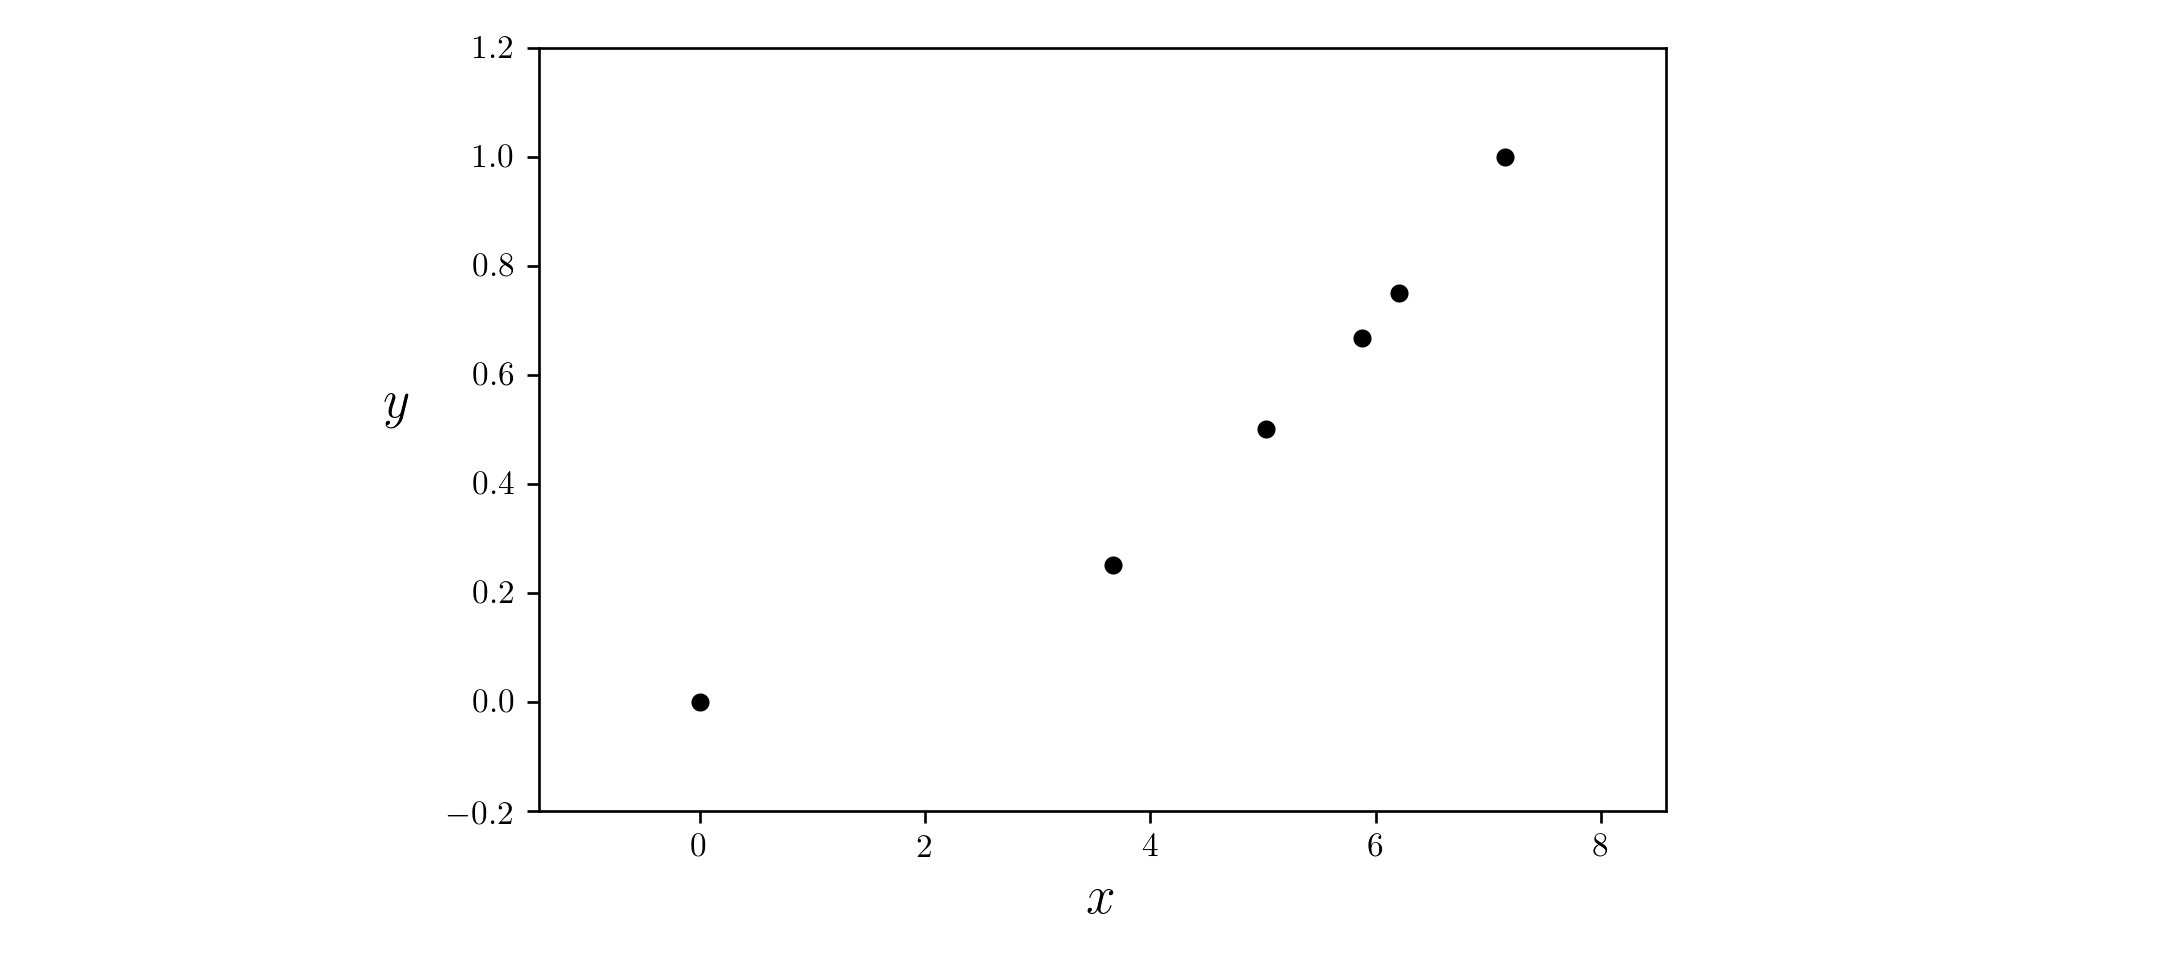

In [46]:
# load data
csvname = datapath + 'galileo_ramp_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

The data here certainly displays a nonlinear relationship and by viewing it - and using his physical intuition Galileo - intuited a *quadratic* relationship.  Or in our jargon that for some $w_0$, $w_1$, and $w_2$ the modeling function 

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + xw_1 + x^2w_2
\end{equation}

provides the correct sort of nonlinearity to explain this data (albeit when the parameters are tuned correctly).  

Notice here how we have two *unparameterized* feature transformations: the identity $f_1(x) = x$ and the quadratic term $f_2(x) = x^2$, and so we may write the above equivalently as

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + f_1(x)\,w_1 + f_2(x)\,w_2
\end{equation}

which clearly shows how we are seeking out a proper linear relationship in the transformed feature space (which in this case is two-dimensional).  Note here - unlike the previous examples - neither of these feature transformations are *fixed* in that they take in no internal weights.

Below implement both feature transformations in a single `Python` function, the `model` function.

In [47]:
def feature_transforms(x):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(1,3)])   
    return f

As in the previous examples we perform standard normalization on the input of this dataset to speed up gradient descent.  This means that we can think of each of our feature transformations as involving this form of normalization as $f_1(x) = \frac{x - \mu}{\sigma}$ and the quadratic term $f_2(x) = \left(\frac{x - \mu}{\sigma}\right)^2$ where $\mu$ and $\sigma$ are the mean and standard deviation of the input data, which we accomplish by feeding normalized input into each.

In [50]:
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(3,1);
max_its = 50; alpha_choice = 10**(-1);

# run on original data
run1 = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run1.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

Now we can plot our original data and nonlinear fit in the original space (left panel below), as well as transformed data and simultaneous *linear* fit in the transformed feature space (right panel below).  Notice that since we have two features in this instance our linear fit is in a space one dimension higher than the original input space defined by $x$.  In other words, the transformed feature space here has *two* inputs: one defined by each of the two features $f_1$ and $f_2$.

<IPython.core.display.Javascript object>


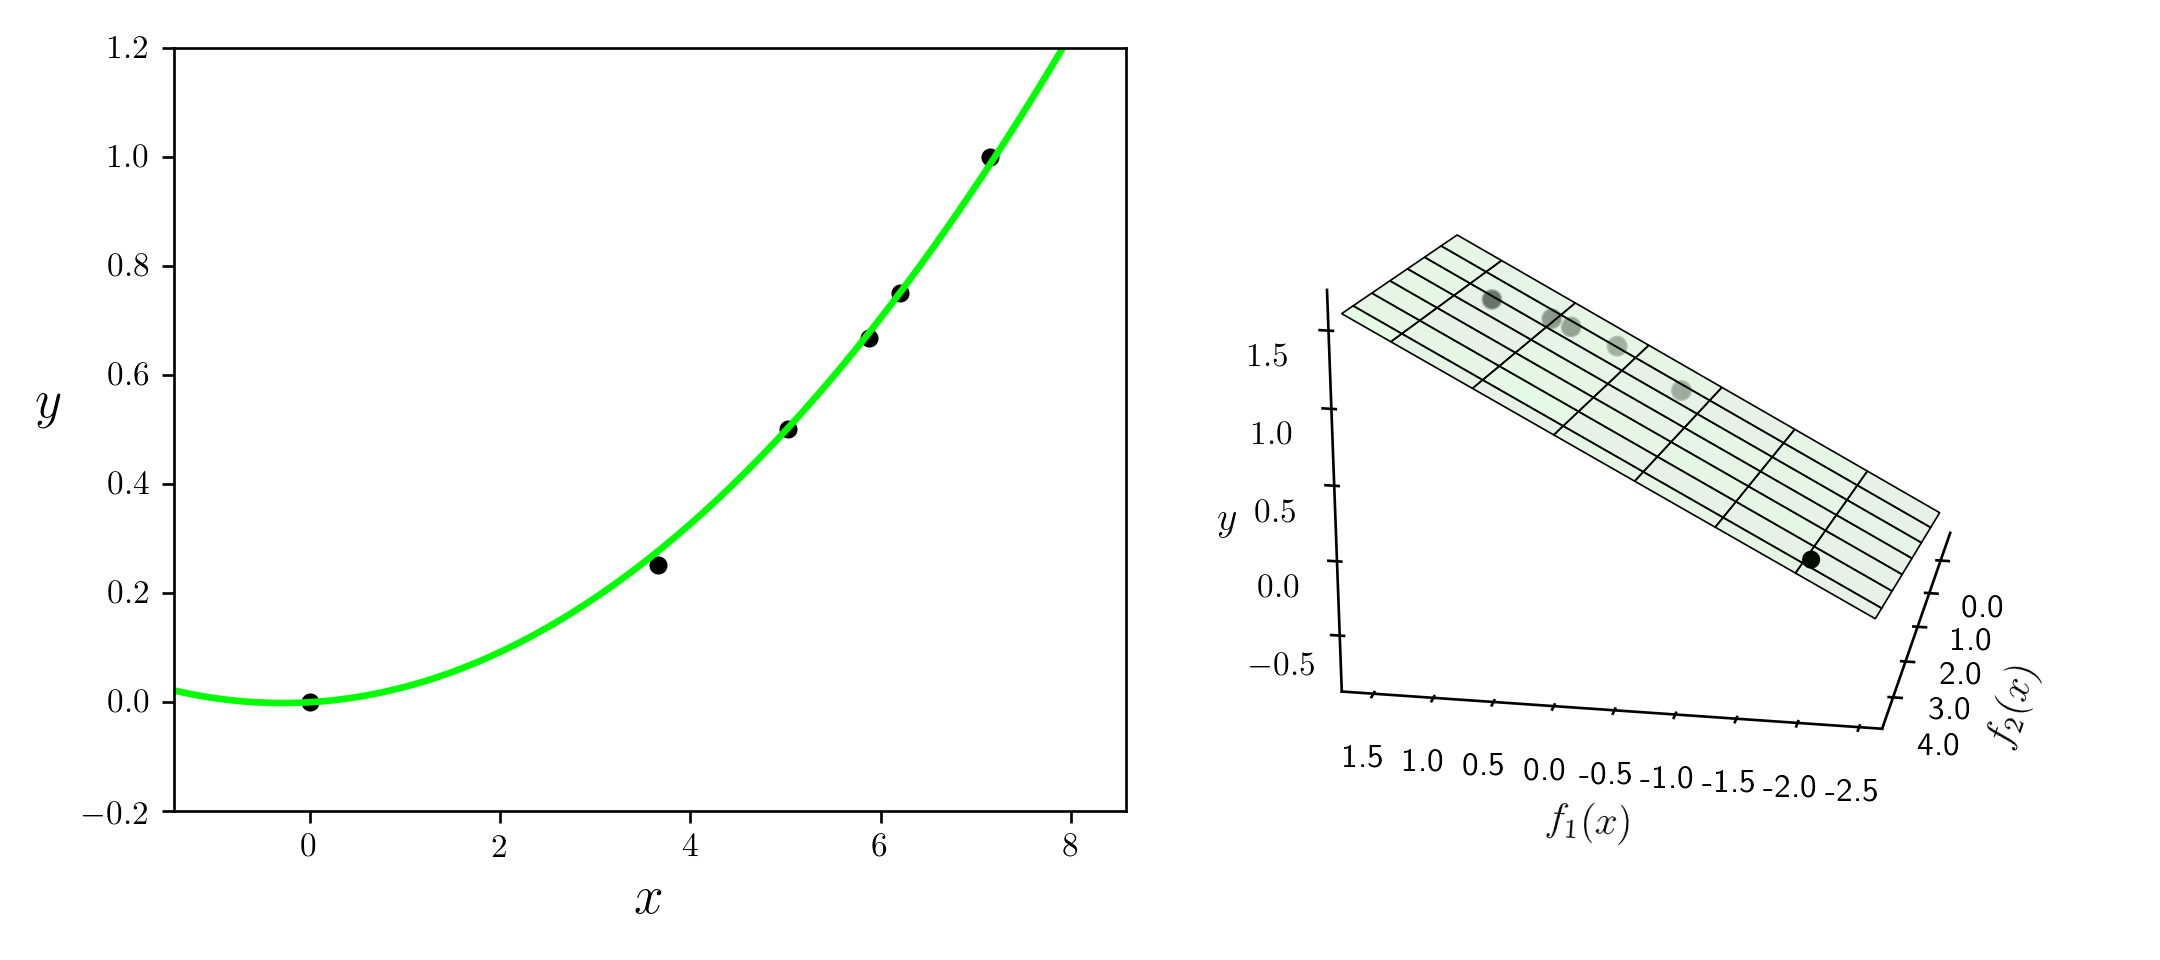

In [51]:
# plot data and fit in original and feature transformed space
ind = np.argmin(run1.cost_history)
w_best = run1.weight_history[ind]
demo.plot_fit_and_feature_space(w_best,run1.model,run1.feature_transforms,normalizer = run1.normalizer,view = [25,100])

This is true more generally speaking: the more feature transforms we use the higher the up we go in terms of the dimensions of our transformed feature space / linear fit!  In general if our original input has dimension $N$ - and is written as $\mathbf{x}$ - and we use a `model` function that employs $B$ nonlinear feature transformations as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

then our original space has $N$ dimensional input, while our transformed feature space is $B$ dimensional.  Note here that the set of all weights $\omega$ contains not only the weights $w_1,\,w_2,...,w_B$ from the linear combination, but also any features's internal parameters as well.